In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [3]:
root = "/content/drive/MyDrive/Bitcoin/"

train_df = pd.read_csv(f"{root}preprocessed/btc_train.csv", index_col="Open time", parse_dates=True)
test_df  = pd.read_csv(f"{root}preprocessed/btc_test.csv", index_col="Open time", parse_dates=True)

feature_info = joblib.load(f"{root}preprocessed/feature_info.pkl")

xgb_features = feature_info["base_features"]
print("Using features:", xgb_features)

Using features: ['lag_1', 'lag_2', 'lag_3', 'vol_7', 'vol_14', 'vol_30', 'vol_ratio', 'ewm_vol_7', 'ma_return_3', 'ma_return_5', 'volume_change', 'volume_vol_5', 'high_low_range', 'close_open_ratio', 'momentum_3']


In [4]:
X_train = train_df[xgb_features]
y_train = train_df["log_return_norm"]

X_test  = test_df[xgb_features]
y_test  = test_df["log_return_norm"]

In [5]:
tscv = TimeSeriesSplit(n_splits=5)
xgb_preds_train = np.full(len(X_train), np.nan)

print("\nGenerating XGBoost OOS predictions with TimeSeriesSplit...\n")

for fold, (tr_idx, val_idx) in enumerate(tscv.split(X_train)):
    print(f"Fold {fold+1}: Train {tr_idx[0]}:{tr_idx[-1]},  Val {val_idx[0]}:{val_idx[-1]}")

    X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    X_val = X_train.iloc[val_idx]

    temp_model = xgb.XGBRegressor(
        n_estimators=2000,
        learning_rate=0.01,
        max_depth=8,
        subsample=1.0,
        colsample_bytree=1.0,
        reg_lambda=0.1,
        objective="reg:squarederror",
        random_state=42,
        tree_method="hist")

    temp_model.fit(X_tr, y_tr, verbose=False)

    preds = temp_model.predict(X_val)
    xgb_preds_train[val_idx] = preds

print("\nOOS XGBoost predictions generated.\n")


Generating XGBoost OOS predictions with TimeSeriesSplit...

Fold 1: Train 0:379,  Val 380:759
Fold 2: Train 0:759,  Val 760:1139
Fold 3: Train 0:1139,  Val 1140:1519
Fold 4: Train 0:1519,  Val 1520:1899
Fold 5: Train 0:1899,  Val 1900:2279

OOS XGBoost predictions generated.



In [6]:
xgb_model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=8,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_lambda=0.1,
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist"
)

xgb_model.fit(X_train, y_train, verbose=False)

# ---- Test predictions ----
xgb_preds_test = xgb_model.predict(X_test)

In [7]:
def directional_accuracy(actual, pred):
    return np.mean(np.sign(actual) == np.sign(pred)) * 100

# Directional Accuracy
dir_acc = directional_accuracy(y_test, xgb_preds_test)

# Correlation
correlation = np.corrcoef(y_test.values, xgb_preds_test)[0, 1]

# R^2
r2 = r2_score(y_test.values, xgb_preds_test)

# Sharpe Ratio
strategy_returns = np.sign(xgb_preds_test) * y_test.values
sharpe = strategy_returns.mean() / (strategy_returns.std() + 1e-8)

print(f"Directional Accuracy: {dir_acc:.2f}%")        # slightly better than random guesssing
print(f"Correlation:          {correlation:.4f}")     # no meaningful predictive relationship
print(f"R²:                   {r2:.4f}")              # model explains -% of return variance
print(f"Sharpe Ratio:         {sharpe:.4f}")          # not tradeable

Directional Accuracy: 52.46%
Correlation:          0.0828
R²:                   -0.3071
Sharpe Ratio:         0.0485


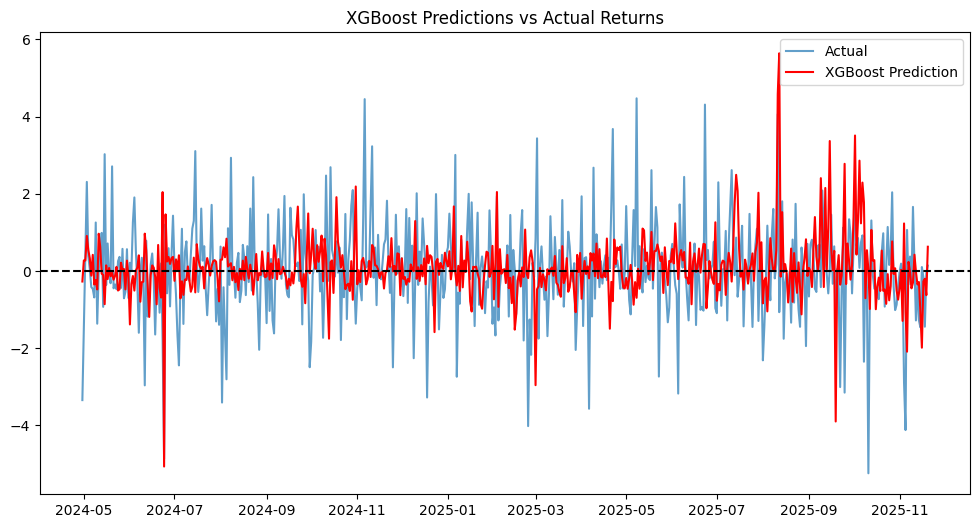

In [8]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Actual", alpha=0.7)
plt.plot(y_test.index, xgb_preds_test, label="XGBoost Prediction", color="red")
plt.axhline(0, color="black", linestyle="--")
plt.title("XGBoost Predictions vs Actual Returns")
plt.legend()
plt.show()

In [9]:
# Save model
joblib.dump(xgb_model, f"{root}models/xgb_model.pkl")
print("Saved XGBoost model.")

# Save predictions
np.save(f"{root}predictions/xgb_train_preds.npy", xgb_preds_train)
np.save(f"{root}predictions/xgb_test_preds.npy", xgb_preds_test)
print("Saved XGBoost predictions.")

Saved XGBoost model.
Saved XGBoost predictions.
